<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Librerias" data-toc-modified-id="1.-Librerias-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>1. Librerias</a></span></li><li><span><a href="#2.-Arquitectura-de-red-del-modelo" data-toc-modified-id="2.-Arquitectura-de-red-del-modelo-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>2. Arquitectura de red del modelo</a></span></li><li><span><a href="#3.-Optimizador,-función-error" data-toc-modified-id="3.-Optimizador,-función-error-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>3. Optimizador, función error</a></span></li><li><span><a href="#4.-Preparamos-los-datos" data-toc-modified-id="4.-Preparamos-los-datos-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>4. Preparamos los datos</a></span></li><li><span><a href="#5.-Entrenamiento" data-toc-modified-id="5.-Entrenamiento-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>5. Entrenamiento</a></span></li><li><span><a href="#6.-Evaluamos-los-resultados" data-toc-modified-id="6.-Evaluamos-los-resultados-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>6. Evaluamos los resultados</a></span></li><li><span><a href="#7.-Guardamos-el-modelo-para-futuras-evaluaciones" data-toc-modified-id="7.-Guardamos-el-modelo-para-futuras-evaluaciones-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>7. Guardamos el modelo para futuras evaluaciones</a></span></li></ul></div>

![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

# Clasificación de imágenes con Deep Learning (CIFAR-10)

CIFAR es un acrónimo de "Canadian Institute for Advanced Research" y CIFAR-10 el dataset fue desarrollado junto a CIFAR-100 por investigadores del instituto.

El dataset se compone de 60.000 imagenes en color (3 canales) de 32 × 32 píxeles de objetos de 10 clases. Cada muestra del dataset dispone de una de las siguientes etiquetas:

- 0: avión
- 1: automóvil
- 2: pájaro
- 3: gato
- 4: ciervo
- 5: perro
- 6: rana
- 7: caballo
- 8: nave
- 9: camión

El siguiente ejemplo carga el conjunto de datos CIFAR-10 usando la API de Keras y crea un gráfico de las primeras nueve imágenes en el conjunto de datos de entrenamiento.

## 1. Librerias

Para empezar carguemos esas librerias que nos hacen falta

In [ ]:
from tensorflow import keras as ks
from matplotlib import pyplot
import numpy as np
import time
import datetime
import tensorflow as tf
import os
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
#from keras.preprocessing.image import ImageDataGenerator
import sys
import seaborn as sns
sns.set_theme(style="darkgrid")

# Load the TensorBoard notebook extension
%load_ext tensorboard

## Preparación del dataset

In [ ]:

# Cargar datos
(X_train, y_train), (X_test, y_test) = ks.datasets.cifar10.load_data()

# Normalizar datasets
X_train = X_train / 255.0
X_test = X_test / 255.0

# Test de validación para utilizarlo a la vez que se realiza el entrenamiento
X_val = X_train[-10000:]
y_val = y_train[-10000:]

X_train = X_train[:-10000]
y_train = y_train[:-10000]

# Resumir dataset cargado
print('Resumen de los dataset de entrenamiento, ')
print(f'Train: X={X_train.shape}, y={y_train.shape}')
print(f'Val: X={X_val.shape}, y={y_val.shape}')
print(f'Test: X={X_test.shape}, y={y_test.shape}')
print(2*'\n')

170508288/170498071 [==============================] - 2s 0us/step
Resumen de los dataset de entrenamiento, 
Train: X=(40000, 32, 32, 3), y=(40000, 1)
Val: X=(10000, 32, 32, 3), y=(10000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)





## 2. Ejemplo

Se cargarán los datos de CIFAR10 directamente de las librerias de Keras. Estos ya estan dispuestos en train and test

**IMPORTANTE** 
La red neuronal requiere que los inputs sean números reales, y lo haremos forzando la division de los valores de dentro de las matrices 28x28 (que tienen valoress del 0 al 255) por 255.0 (un real).

Pintemos una muestra de las imagenes del dataset CIFAR10, a ver si se parece en algo a lo que esperamos. Primero, vemos que tipos de datos tengo, después mapeamos esas matrices en una escala de grises utilizando el método .get_cmap() de PlotLy con los nueve primeros números del dataset.

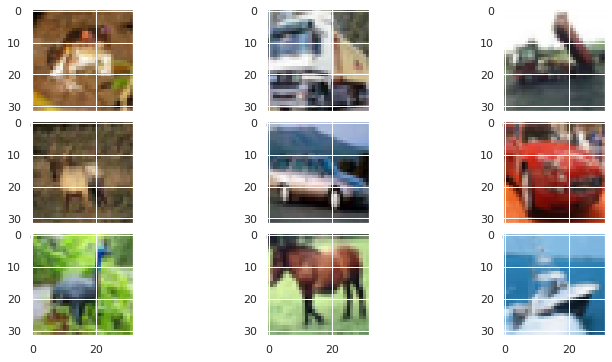

In [ ]:
# Visualizar 9 imagenes del conjunto de entrenamiento
plt.figure(figsize=(12,6))
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.subplots_adjust(hspace = 0.1)
plt.show()

## Model Evaluation Test Harness

El dataset disponible en Keras ya tiene un conjunto de datos dividido en test y train. Como alternativa, se puede utilizar "validación cruzada". En este caso no utilizaremos la validación cruzada de k-fold.

Con el fin de conseguir modular el trabajo para evaluar diferentes arquitecturas se implementarán diferentes funciones para los distintos pasos que sigue el entrenamiento. Estos pasos son:

- __'load_cifar10'__. Cargar los datos

- __'preprocessing_cifar10'__. Pre-procesamiento del dataset.

    - Las imágenes se encuentran codificadas por 8 bits y, por lo tanto, el valor de sus píxeles puede tomar valores enteros en el rango [0, 255] y se escalarán al rango [0,1].

    - One-Hot Encoding. Codificación de las etiquetas de las clases transformando el valor entero en un vector binario de n elementos (10 por ser 10 imágenes) con un valor de 1 para el índice del valor de la clase. 
    
    Nota: Cuando añadimos convoluciones, necesitamos "pre-tratar los datos", porque la convolución espera una matriz de 4 campos (más parecido a "imagenes"), en el caso de MNIST. CIFAR10 ya tiene el shape adecuado, así que no tenemos que hacer nada, pero como siempre decimos: es mejor que comprobeis su tamaño.

Por eso, al salir de la Convolution, hay que hacer un Flatten, porque las capas FullDense esperan arrays, no matrices!!

Luego lo imprimimos para ver que todo está correcto

- __'model'__. Definición del modelo (esta función varía para cada prueba realizada). 

  - Es mejor utilizar un conjunto de datos de validación separado dividiendo el conjunto de datos del train en conjuntos de train y validación. Para ello se tomarán 40000 imágenes en el conjunto de entrenamiento y un total de 10000 en el de validación.

  - El conjunto de datos de test se utilizará como un conjunto de datos de validación con el que evaluar al final de cada época de entrenamiento. Esto dará como resultado un registro de las puntuaciones de evaluación del modelo en el train y el conjunto de datos de test en cada época para visualizarla.

- __'eval_model'__. Requerire que se especifique el número de épocas de entrenamiento y el tamaño del lote. 

- __'summarize_diagnostics'__. Mostrar diagnóstico del modelo. Una vez evaluado el modelo se procede con la presentación de resultados. Los resultados se dividirán en dos secciones:

  - Diagnóstico de comportamiento.

  - Visualización del rendimiento del conjunto de entrenamiento y test durante el entrenamiento con el fin de evaluar si el modelo está sobreajustado, desajustado o tiene un buen ajuste para el conjunto de datos. Se creará una figura para dos su-figuras y otra para la precisión. La línea azul representará el rendimiento del conjunto de train y la naranja el rendimiento para test. 


  - __'make_predicctions'__. Aplica la red neuronal a una serie de imagenes de test y las visualiza.

Para entrenar el modelo:

- Debe entrenarse al modelo con los datos convertidos al formato que espera la convolución.

- Empezaremos con 200 epocs, es decir, 30 pasadas completas del dataset (que a su vez sera con mini-batches internamente), fijando un batch de 64

- Es posible definir además si disponemos de varias CPUs, GPUs, y si queremos ir validando datos a cada fin de epoch.

In [ ]:
def load_cifar10():
  """
  Cargar datos del dataset CIFAR10 desde keras. Se trata de un conjunto de 60000 imágenes divididas
  en train (50000) y test (10000) en formato RGB y tamaño 32x32.
  """
  # Cargar datos desde keras
  (X_train, y_train), (X_test, y_test) = ks.datasets.cifar10.load_data()

  # Conjunto de validacion
  X_val = X_train[-10000:]
  y_val = y_train[-10000:]
  X_train = X_train[:-10000]
  y_train = y_train[:-10000]

  return X_train, y_train, X_test, y_test, X_val, y_val


def preprocessing_cifar10(X_train, y_train, X_test, y_test, X_val, y_val):
  """
  Aplicar OneHot Encoding y normalización
  """
  # OneHot Encoding
  #y_train = ks.utils.to_categorical(y_train)
  #y_test  = ks.utils.to_categorical(y_test)
  #y_val  = ks.utils.to_categorical(y_val)

  # Normalización
  X_train = X_train / 255.0
  X_test = X_test / 255.0
  X_val = X_val / 255.0

  return X_train, y_train, X_test, y_test, X_val, y_val


def summarize_diagnostics10(history):
  """
  Mostrar diagnóstico del modelo.
  """
  fig, (ax1, ax2) = pyplot.subplots(nrows=2, ncols=1, figsize=(14,14))

  # Loss
  sns.lineplot(data=history.history['loss'], color='blue', label='train', ax=ax1)
  sns.lineplot(data=history.history['val_loss'], color='orange', label='val', ax=ax1)
  _=ax1.set_xlabel('epochs')
  _=ax1.set_title('Cross Entropy Loss')


  # Classification Accuracy
  sns.lineplot(data=history.history['accuracy'], color='blue', label='train', ax=ax2)
  sns.lineplot(data=history.history['val_accuracy'], color='orange', label='test', ax=ax2)
  _=ax2.set_xlabel('epochs')
  _=ax2.set_title('Classification Accuracy')


def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label[0]),
                                color=color)
  
def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label[0]].set_color('blue')

  
def make_predictions(model, x_test, y_test):
  # Calcular predicciones
  predictions = model.predict(x_test)

  # Visualización de predicción
  num_rows = 5
  num_cols = 4
  start = 650
  num_images = num_rows*num_cols
  plt.figure(figsize=(2*2*num_cols, 2*num_rows))
  for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i+start, predictions[i+start], y_test, x_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i+start, predictions[i+start], y_test)
  plt.tight_layout()
  plt.show()


def pipeline(name):
  """
  Lanzar simulación del sistema de entrenamiento y evaluación para CIFAR10
  """
  # Load dataset
  print('######### ETAPA 1: CARGAR DATASET #########')
  X_train, y_train, X_test, y_test, X_val, y_val = load_cifar10()

  # Pre-processing
  print('######### ETAPA 2: PRE-PROCESAMIENTO #########')
  X_train, y_train, X_test, y_test, X_val, y_val = preprocessing_cifar10(X_train, y_train, X_test, y_test, X_val, y_val)
  

  # Define model
  print('######### ETAPA 3: DEFINIR MODELO #########')
  model = define_model(name)
  
  # Callbacks
  t = time.perf_counter()

  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
  callback_val_loss = EarlyStopping(monitor="val_loss", patience=20)
  callback_val_accuracy = EarlyStopping(monitor="val_accuracy", patience=20)


  # Entrenamiento
  print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
  print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))
  print('Validation: X=%s, y=%s' % (X_val.shape, y_val.shape))
  history = model.fit(X_train, y_train, epochs=200, use_multiprocessing=False, 
                      batch_size= 512,
                      validation_data=(X_val, y_val),
                      callbacks=[
                                 tensorboard_callback,
                                 callback_val_loss, 
                                 callback_val_accuracy
                                 ]
                      )


  elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

  
  # Evaluación del modelo
  print('######### ETAPA 4: Evaluar modelo #########')
  _, acc = model.evaluate(X_test, y_test)

  # Mostrar resultados
  print('######### ETAPA 5: DIAGNOSTICO DEL MODELO #########')
  print('Tiempo de entrenamiento =', elapsed_time)
  print('Accuracy = {:.3f}%'.format(acc*100))

  # Learning curves
  summarize_diagnostics10(history)

  # Calcular predicciones
  print('######### ETAPA 6: PREDICCIONES #########')
  make_predictions(model, X_test, y_test)

  return history


def pipeline_data_augmentation(name):
  """
  Lanzar simulación del sistema de entrenamiento y evaluación para CIFAR10 
  utilizando data augmentation
  """
  # Load dataset
  print('######### ETAPA 1: CARGAR DATASET #########')
  X_train, y_train, X_test, y_test, X_val, y_val = load_cifar10()

  # Pre-processing
  print('######### ETAPA 2: PRE-PROCESAMIENTO #########')
  X_train, y_train, X_test, y_test, X_val, y_val = preprocessing_cifar10(X_train, y_train, X_test, y_test, X_val, y_val)
  

  # Define model
  print('######### ETAPA 3: DEFINIR MODELO #########')
  model = define_model(name)
  
  # Callbacks
  t = time.perf_counter()

  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
  callback_val_loss = EarlyStopping(monitor="val_loss", patience=20)
  callback_val_accuracy = EarlyStopping(monitor="val_accuracy", patience=20)


  # Descripción de datasets
  print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
  print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))
  print('Validation: X=%s, y=%s' % (X_val.shape, y_val.shape))

  # Encoder
  le = LabelEncoder()
  le.fit(y_train)
  y_train_encoded = le.transform(y_train.ravel())
  y_val_encoded = le.transform(y_val.ravel())
  y_test_encoded = le.transform(y_test.ravel())

  # Data Augmentation
  train_datagen = ImageDataGenerator(
      
      rescale=1.,
      rotation_range=50,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      width_shift_range=0.2,
      height_shift_range=0.2,
      fill_mode='nearest'
      )

  train_generator = train_datagen.flow(
      X_train,  # Aquí hay que usar datos NO re-escalados... de ahi que no usemos x_train_rescaled!
      y_train_encoded,
      batch_size=30
  )

  validation_datagen = ImageDataGenerator(
      rescale=1.
      )

  validation_generator = validation_datagen.flow(
      X_val, # Aquí hay que usar datos NO re-escalados... de ahi que no usemos x_val_rescaled!
      y_val_encoded,
      batch_size=100
  )

  # Entrenamiento
  history = model.fit(train_generator, 
                      epochs=200, 
                      use_multiprocessing=False, 
                      steps_per_epoch=train_generator.n//train_generator.batch_size,
                      validation_steps=validation_generator.n//validation_generator.batch_size,
                      batch_size= 512,
                      validation_data=validation_generator,
                      callbacks=[
                                 tensorboard_callback,
                                 callback_val_loss,
                                 callback_val_accuracy
                                 ]
                      )


  elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

  
  # Evaluación del modelo
  print('######### ETAPA 4: Evaluar modelo #########')
  _, acc = model.evaluate(X_test, y_test)

  # Mostrar resultados
  print('######### ETAPA 5: DIAGNOSTICO DEL MODELO #########')
  print('Tiempo de entrenamiento =', elapsed_time)
  print('Accuracy = {:.3f}%'.format(acc*100))

  # Learning curves
  summarize_diagnostics10(history)

  # Calcular predicciones
  print('######### ETAPA 6: PREDICCIONES #########')
  make_predictions(model, X_test, y_test)

  return history

## Tensorboard

In [ ]:

%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 493), started 0:34:38 ago. (Use '!kill 493' to kill it.)

<IPython.core.display.Javascript object>

## 5. Arquitectura de red del modelo


### Modelo Base
Un modelo de referencia establecerá un rendimiento mínimo del modelo con el que se pueden comparar todos nuestros otros modelos, así como una arquitectura del modelo que podemos utilizar como base de estudio y mejora.

El punto de partida es una red con una sola capa clasificadora de salida (modelo básico).

######### ETAPA 1: CARGAR DATASET #########
######### ETAPA 2: PRE-PROCESAMIENTO #########
######### ETAPA 3: DEFINIR MODELO #########
Model: Modelo_Base
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                98336     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 98,666
Trainable params: 98,666
Non-trainable params: 0
_________________________________________________________________
Train: X=(40000, 32, 32, 3), y=(40000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)
Validation: X=(10000, 32, 32, 3), y=(10000, 1)
Epoch 1/200
79/79 [==============================] - 2s 13ms/step - loss: 2.3031 - accuracy: 0.135

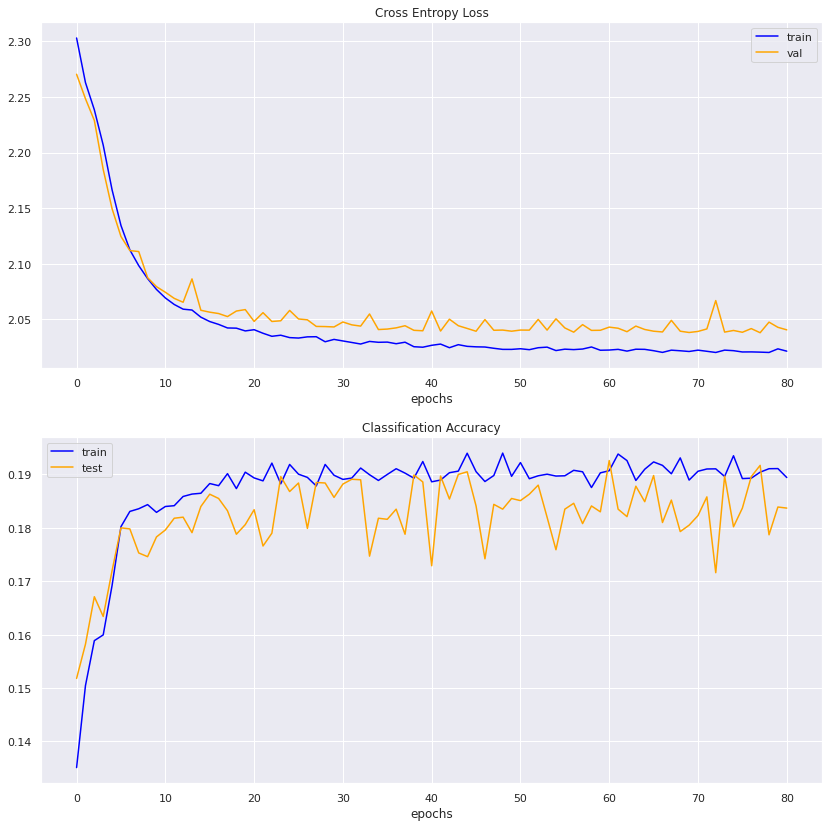

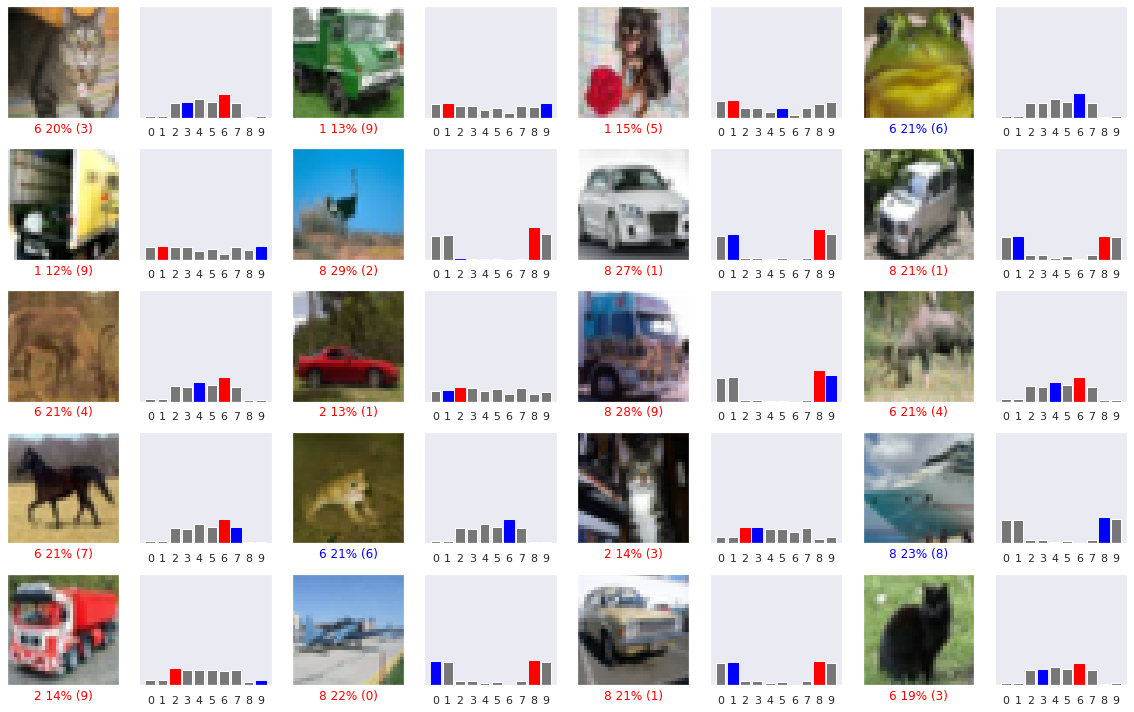

In [ ]:
def define_model(name):
  print(f'Model: {name}')
  model = ks.Sequential(name=name)

  # BLOQUE 1 - Clasificador - Salida de la red.
  model = ks.Sequential()
  model.add(ks.layers.Flatten(input_shape=(32,32,3)))
  model.add(ks.layers.Dense(32, activation='relu'))
  model.add(ks.layers.Dense(10, activation='softmax'))

  # Compilar modelo
  model.compile(optimizer='Adam', 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
 
  # Resumen
  model.summary()

  return model

# Lanzar pipeline
history=pipeline('Modelo_Base')

### Modelo 1

La arquitectura se define en:

- Detector de características. Consiste en una capa ce convolución con filtros 3x3 seguida de una capa de agrupación de máximos. Juntas, estas capas forman un bloque, y estos bloques pueden repetirse donde el número de filtros en cada bloque se incrementa con la profundidad de la red, como 32, 64, 128, 256 para los primeros cuatro bloques del modelo (padding). El padding se utiliza en las capas convolucionales para garantizar que la altura y la anchura de los mapas de características de salida coincidan con las entradas de las siguientes capas.

- Clasificador. Interpreta las características detectadas y hace una predicción sobre la clase a la que pertenece una determinada imagen. La capa de salida debe tener 10 nodos para las 10 clases y utilizar la función de activación softmax.

Cada capa utilizará la función de activación ReLU y la inicialización de pesos He, que son generalmente las mejores prácticas. 


######### ETAPA 1: CARGAR DATASET #########
######### ETAPA 2: PRE-PROCESAMIENTO #########
######### ETAPA 3: DEFINIR MODELO #########
Model: Modelo_I
Model: "Modelo_I"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                262176    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 263,402
Trainable params: 263,402
Non-trainable params: 0
_________________________________

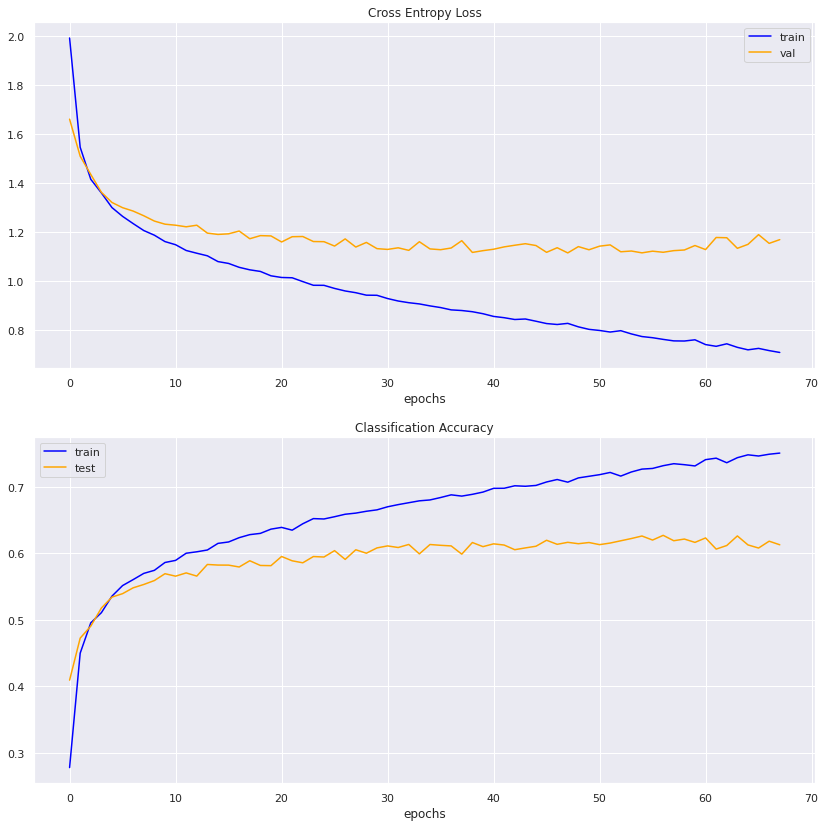

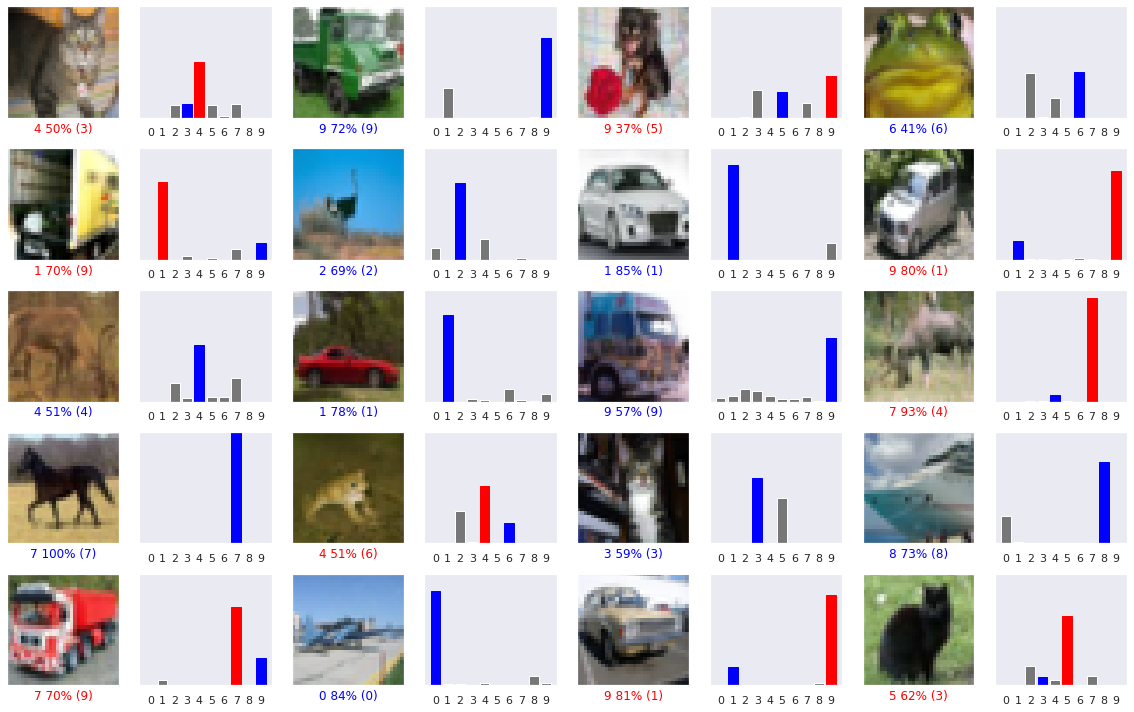

In [ ]:
def define_model(name):
  
  print(f'Model: {name}')
  model = ks.Sequential(name=name)

  # BLOQUE 1 - Detector de características
  model.add(ks.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(ks.layers.MaxPooling2D((2, 2)))

  # BLOQUE 2 - Clasificador - Salida de la red.
  model.add(ks.layers.Flatten())
  model.add(ks.layers.Dense(32, activation='relu', kernel_initializer='he_uniform'))
  model.add(ks.layers.Dense(10, activation='softmax'))

  # Compilar modelo
  model.compile(optimizer='Adam', 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
 
  # Resumen
  model.summary()

  return model

# Lanzar pipeline
history=pipeline('Modelo_I')

### Modelo 2

######### ETAPA 1: CARGAR DATASET #########
######### ETAPA 2: PRE-PROCESAMIENTO #########
######### ETAPA 3: DEFINIR MODELO #########
Model: Modelo_I
Model: "Modelo_I"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 

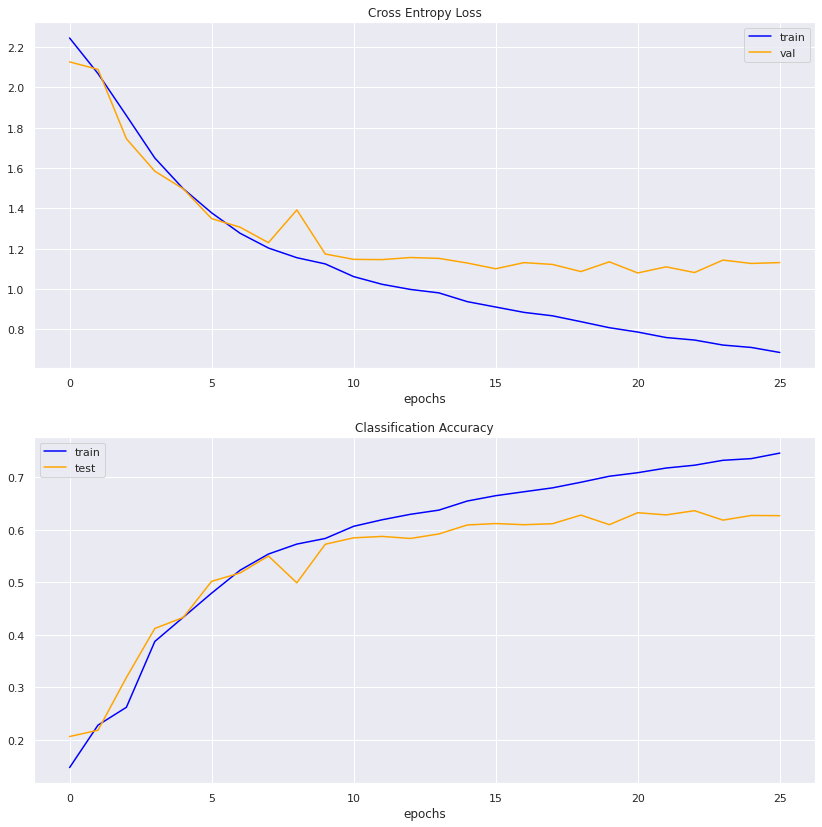

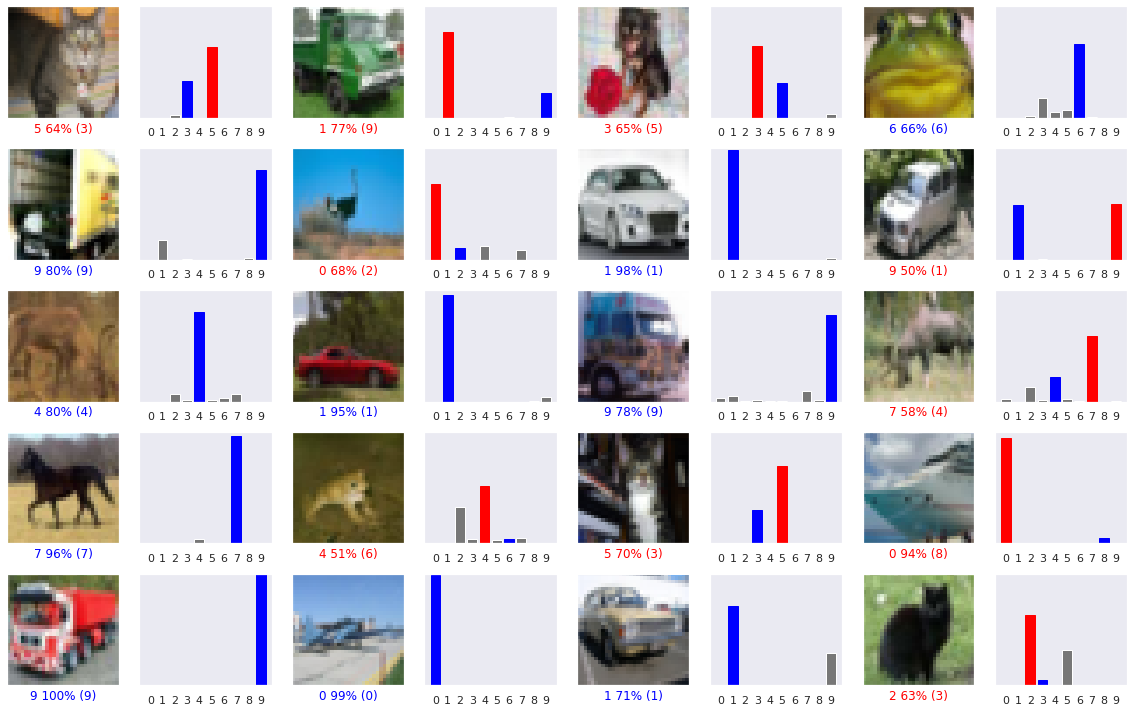

In [ ]:
def define_model(name):
  print(f'Model: {name}')
  model = ks.Sequential(name=name)

  # BLOQUE 1 - Detector de características
  model.add(ks.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(ks.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.MaxPooling2D((2, 2)))

  # BLOQUE 2 - Detector de características
  model.add(ks.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.MaxPooling2D((2, 2)))

  # BLOQUE 3 - Clasificador - Salida de la red.
  model.add(ks.layers.Flatten())
  model.add(ks.layers.Dense(32, activation='relu', kernel_initializer='he_uniform'))
  model.add(ks.layers.Dense(10, activation='softmax'))

  # Compilar modelo
  model.compile(optimizer='Adam', 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
 
  # Resumen
  model.summary()

  return model

# Lanzar pipeline
history=pipeline('Modelo_IMODI')

### Modelo 3

######### ETAPA 1: CARGAR DATASET #########
######### ETAPA 2: PRE-PROCESAMIENTO #########
######### ETAPA 3: DEFINIR MODELO #########
Model: Modelo_III
Model: "Modelo_III"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None,

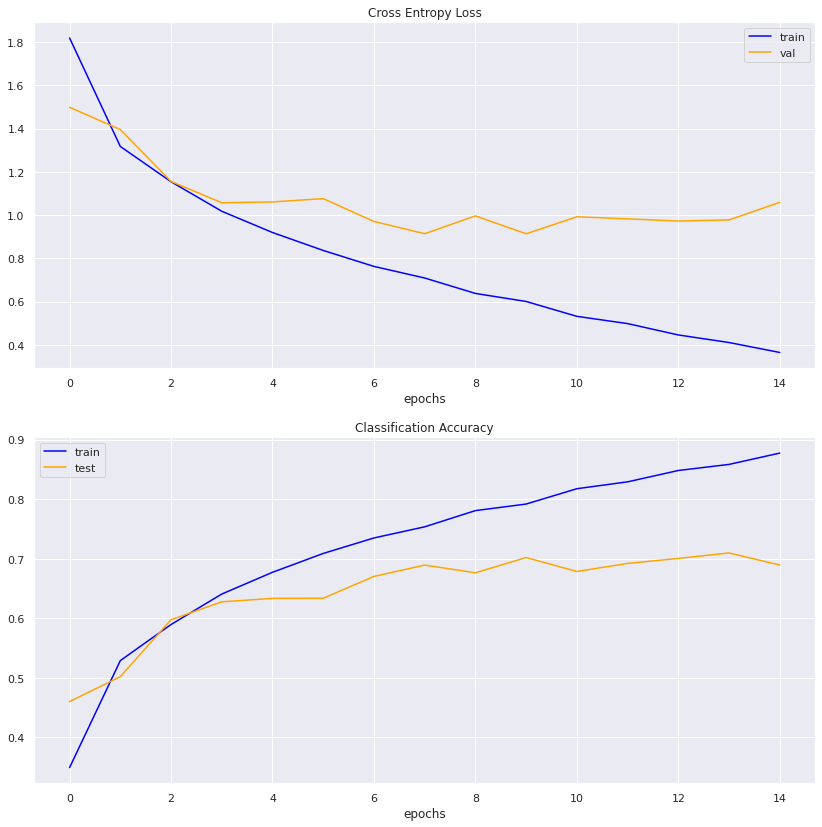

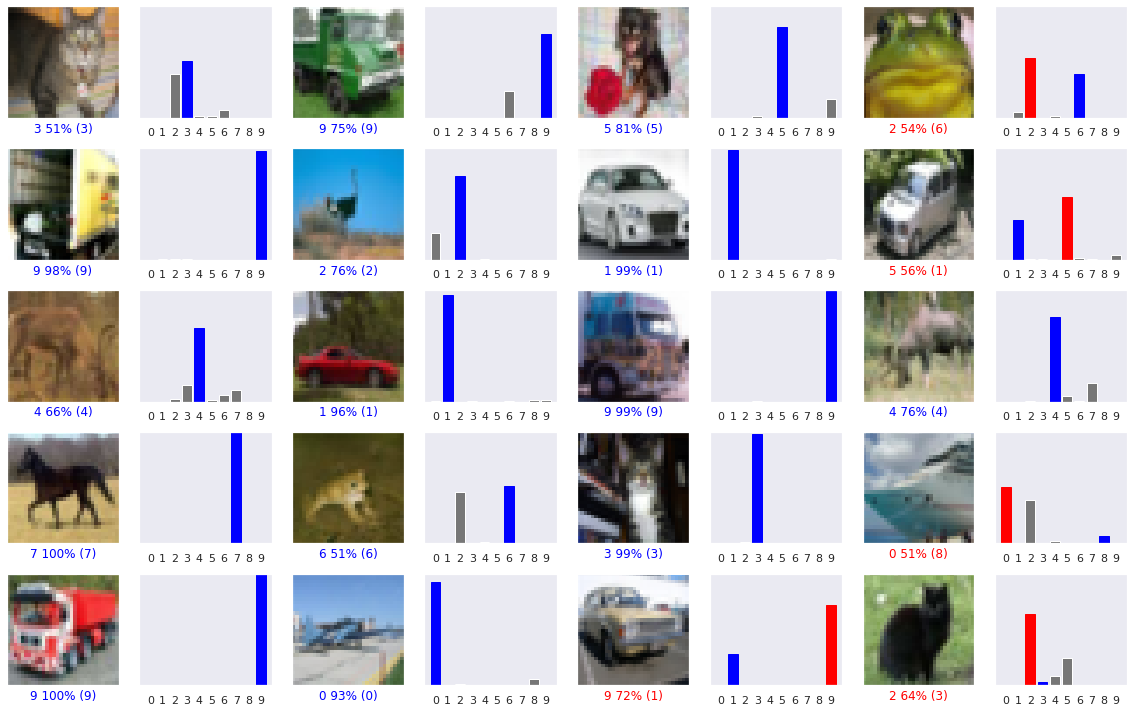

In [ ]:
def define_model(name):
  print(f'Model: {name}')
  model = ks.Sequential(name=name)

  # BLOQUE 1 - Detector de características
  model.add(ks.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(ks.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.MaxPooling2D((2, 2)))

  # BLOQUE 2 - Detector de características
  model.add(ks.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.MaxPooling2D((2, 2)))

  # BLOQUE 3 - Salida de la red.
  model.add(ks.layers.Flatten())
  model.add(ks.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(ks.layers.Dense(10, activation='softmax'))

  # Compilar modelo
  model.compile(optimizer='Adam', 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
 
  # Resumen
  model.summary()

  return model

# Lanzar pipeline
history=pipeline('Modelo_III')

### Modelo 4

######### ETAPA 1: CARGAR DATASET #########
######### ETAPA 2: PRE-PROCESAMIENTO #########
######### ETAPA 3: DEFINIR MODELO #########
Model: Modelo_IV
Model: "Modelo_IV"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8

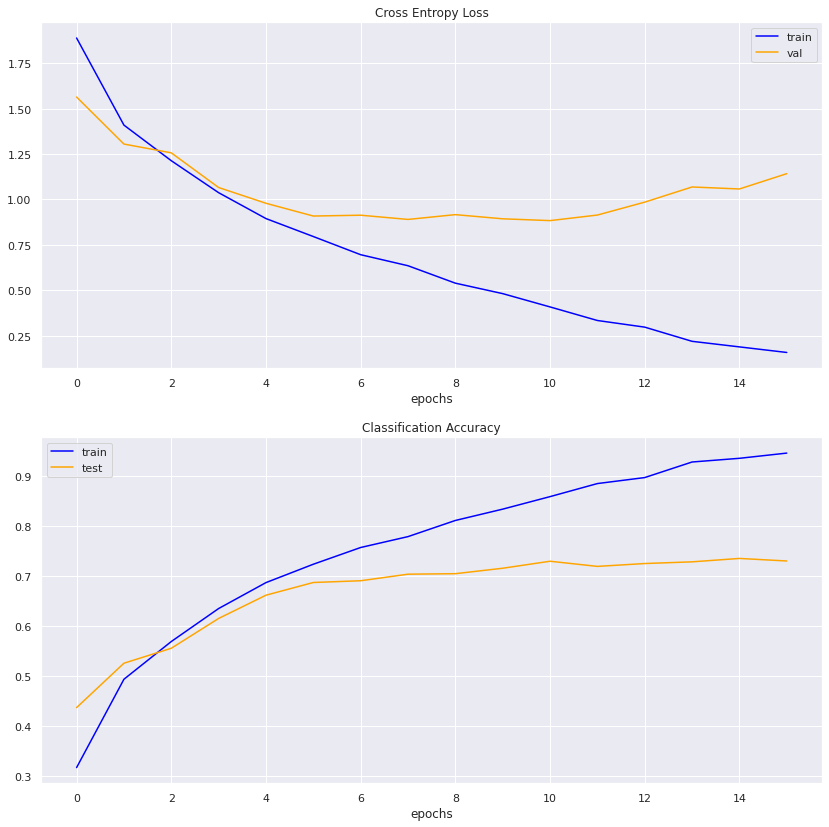

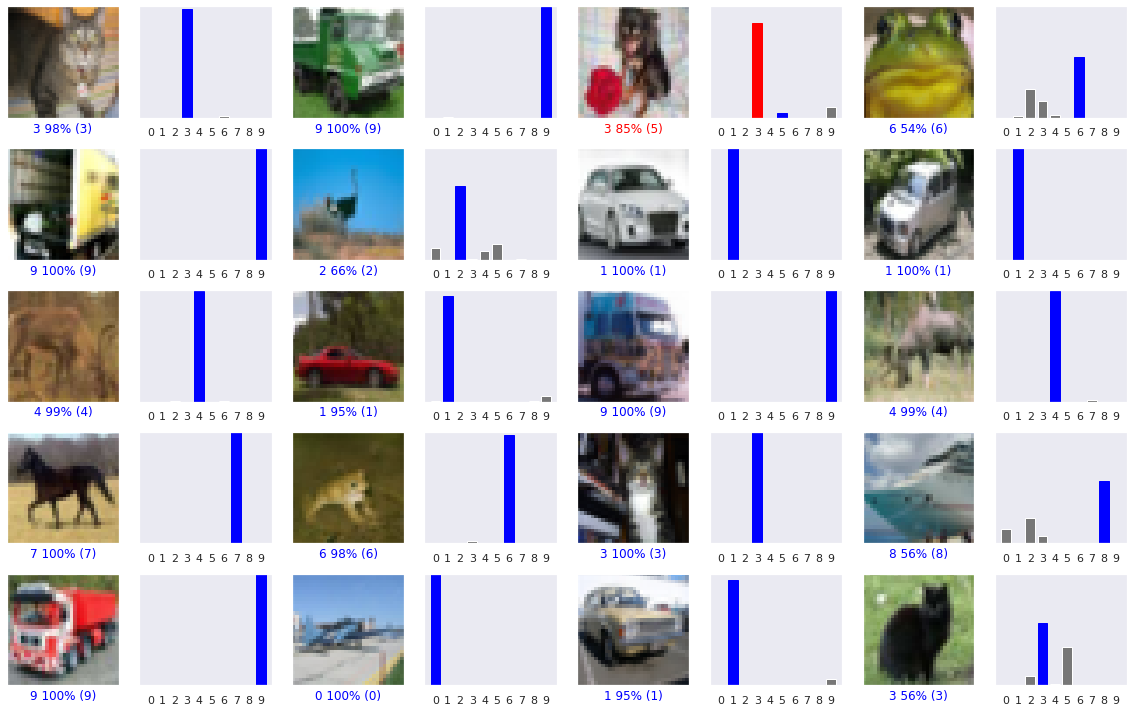

In [ ]:
def define_model(name):
  print(f'Model: {name}')
  # Arquitectura VGG de tres bloques.
  model = ks.Sequential(name=name)

  # Detector de características
  model.add(ks.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(ks.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.MaxPooling2D((2, 2)))

  # BLOQUE 2 - Detector de características
  model.add(ks.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.MaxPooling2D((2, 2)))

  # BLOQUE 3 - Detector de características
  model.add(ks.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.MaxPooling2D((2, 2)))

  # BLOQUE 4 - Salida de la red.
  model.add(ks.layers.Flatten())
  model.add(ks.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(ks.layers.Dense(10, activation='softmax'))

  # Compilar modelo
  model.compile(optimizer='Adam', 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
 
  # Resumen
  model.summary()

  return model

# Lanzar pipeline
history=pipeline('Modelo_IV')

### Modelo 5

######### ETAPA 1: CARGAR DATASET #########
######### ETAPA 2: PRE-PROCESAMIENTO #########
######### ETAPA 3: DEFINIR MODELO #########
Model: Modelo_V
Model: "Modelo_V"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16,

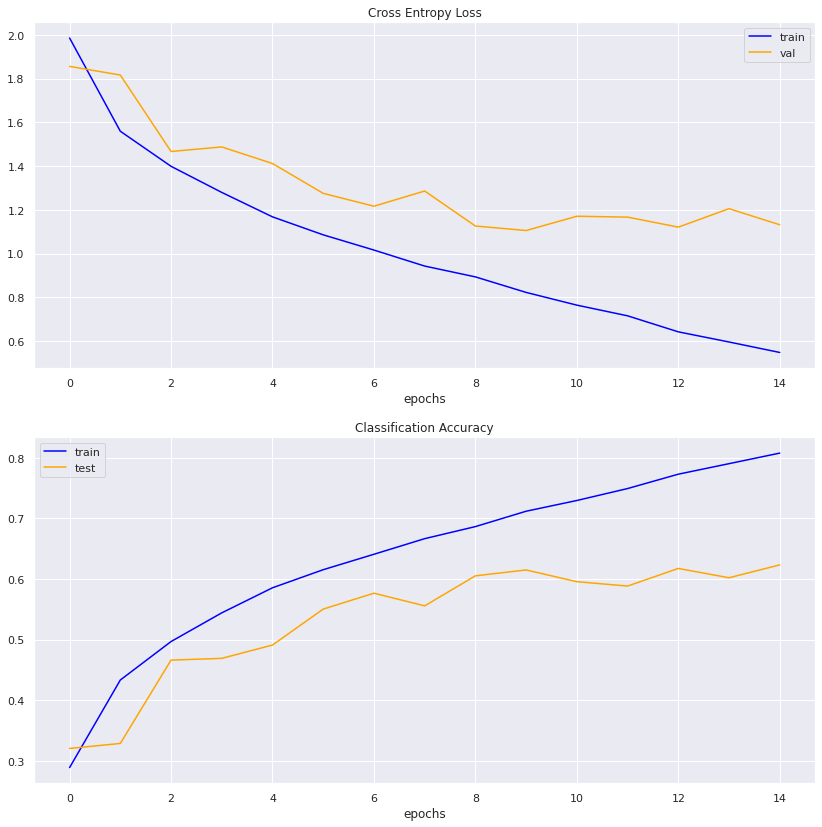

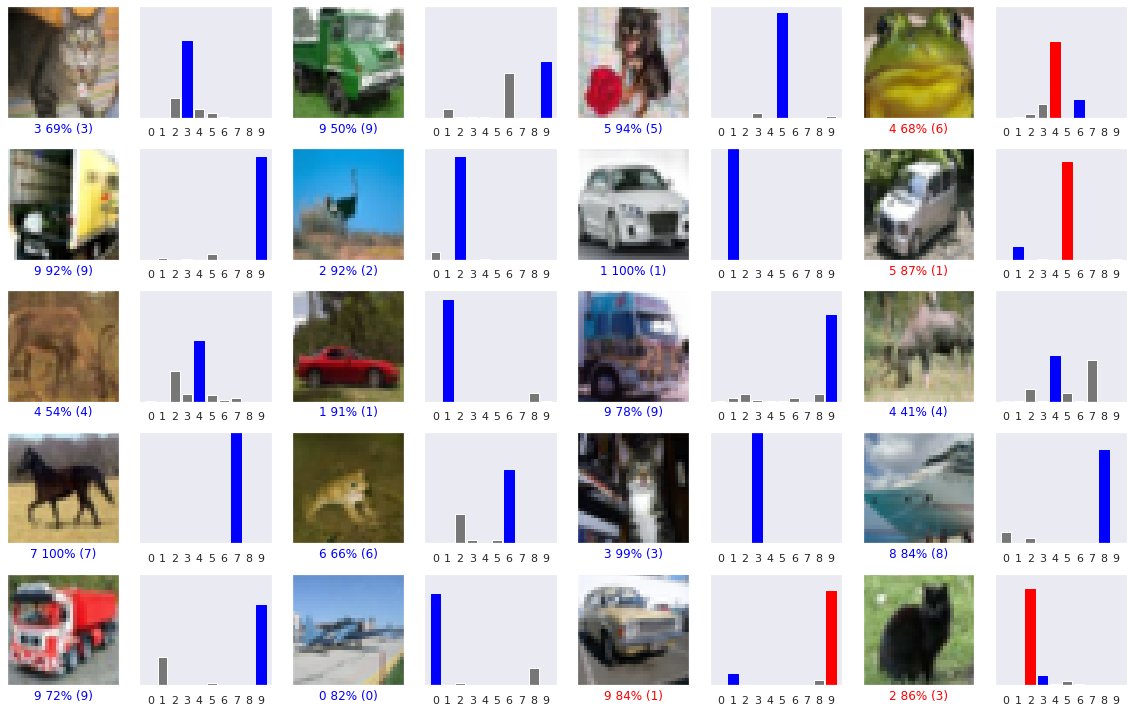

In [ ]:
def define_model(name):
  print(f'Model: {name}')
  # Arquitectura VGG de tres bloques.
  model = ks.Sequential(name=name)

  # Detector de características
  model.add(ks.layers.Dropout(0.2, input_shape=(32, 32, 3)))
  model.add(ks.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.MaxPooling2D((2, 2)))

  # BLOQUE 2 - Detector de características
  model.add(ks.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.MaxPooling2D((2, 2)))

  # BLOQUE 3 - Detector de características
  model.add(ks.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.MaxPooling2D((2, 2)))

  # BLOQUE 4 - Salida de la red.
  model.add(ks.layers.Flatten())
  model.add(ks.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(ks.layers.Dense(10, activation='softmax'))

  # Compilar modelo
  model.compile(optimizer='Adam', 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
 
  # Resumen
  model.summary()

  return model

# Lanzar pipeline
history=pipeline('Modelo_V')

### Modelo 6

######### ETAPA 1: CARGAR DATASET #########
######### ETAPA 2: PRE-PROCESAMIENTO #########
######### ETAPA 3: DEFINIR MODELO #########
Model: Modelo_VI
Model: "Modelo_VI"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 1

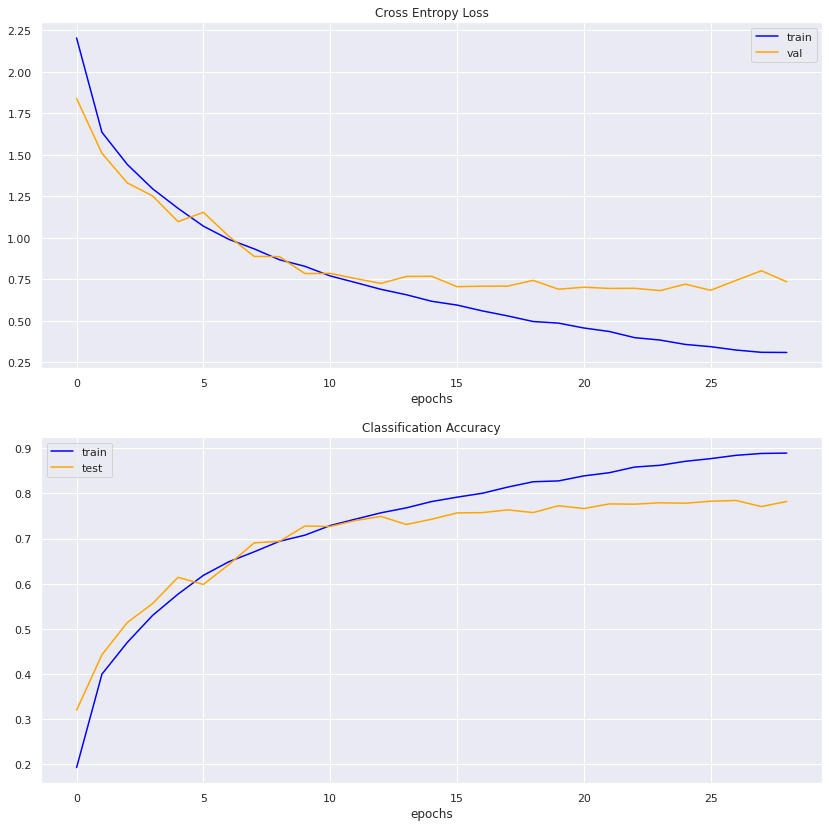

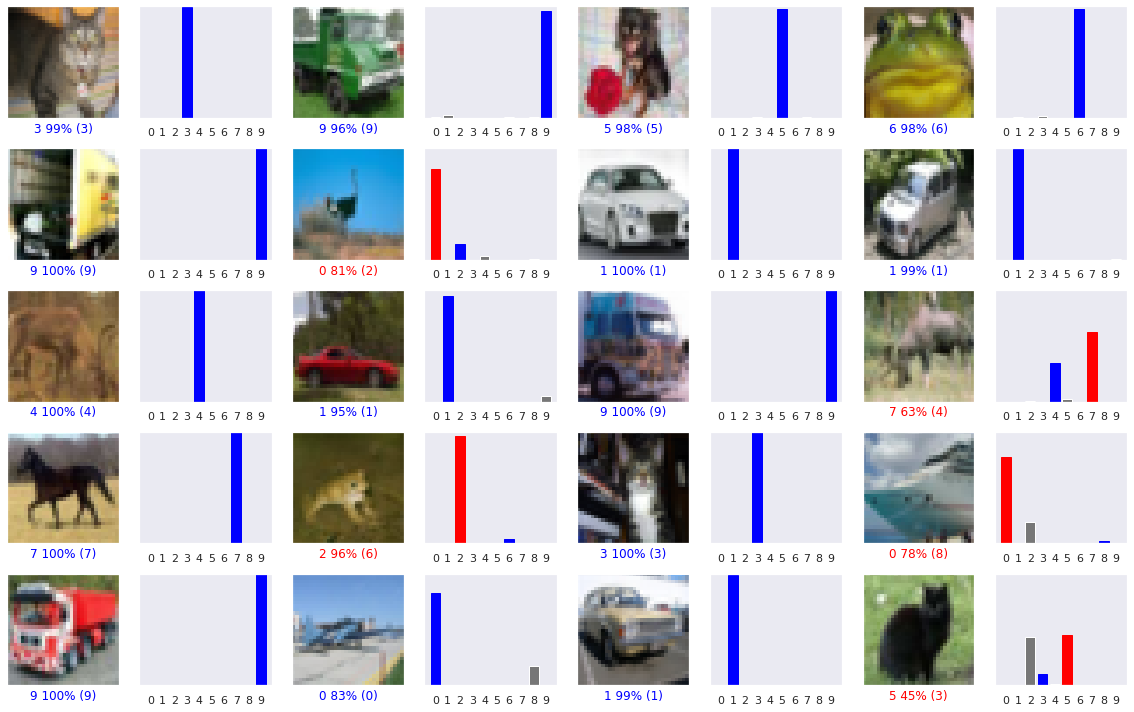

In [ ]:
def define_model(name):
  print(f'Model: {name}')
  # Arquitectura VGG de tres bloques.
  model = ks.Sequential(name=name)

  # Detector de características
  model.add(ks.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(ks.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.MaxPooling2D((2, 2)))
  model.add(ks.layers.Dropout(0.2))

  # BLOQUE 2 - Detector de características
  model.add(ks.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.MaxPooling2D((2, 2)))
  model.add(ks.layers.Dropout(0.2))

  # BLOQUE 3 - Detector de características
  model.add(ks.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.MaxPooling2D((2, 2)))
  model.add(ks.layers.Dropout(0.2))

  # BLOQUE 4 - Salida de la red.
  model.add(ks.layers.Flatten())
  model.add(ks.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(ks.layers.Dense(10, activation='softmax'))

  # Compilar modelo
  model.compile(optimizer='Adam', 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
 
  # Resumen
  model.summary()

  return model

# Lanzar pipeline
history=pipeline('Modelo_VI')

### Modelo 7

######### ETAPA 1: CARGAR DATASET #########
######### ETAPA 2: PRE-PROCESAMIENTO #########
######### ETAPA 3: DEFINIR MODELO #########
Model: Modelo_VII
Model: "Modelo_VII"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None,

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/200
1333/1333 [==============================] - 53s 39ms/step - loss: 2.0975 - accuracy: 0.2652 - val_loss: 1.6099 - val_accuracy: 0.4189
Epoch 2/200
1333/1333 [==============================] - 50s 37ms/step - loss: 1.6853 - accuracy: 0.3822 - val_loss: 1.3873 - val_accuracy: 0.4967
Epoch 3/200
1333/1333 [==============================] - 50s 37ms/step - loss: 1.5649 - accuracy: 0.4370 - val_loss: 1.7013 - val_accuracy: 0.4220
Epoch 4/200
1333/1333 [==============================] - 50s 38ms/step - loss: 1.4749 - accuracy: 0.4697 - val_loss: 1.2747 - val_accuracy: 0.5393
Epoch 5/200
1333/1333 [==============================] - 50s 38ms/step - loss: 1.3938 - accuracy: 0.5022 - val_loss: 1.1925 - val_accuracy: 0.5840
Epoch 6/200
1333/1333 [==============================] - 50s 37ms/step - loss: 1.3410 - accuracy: 0.5244 - val_loss: 1.2981 - val_accuracy: 0.5473
Epoch 7/200
1333/1333 [==============================] - 50s 37ms/step - loss: 1.2901 - accuracy: 0.5468 - val_loss: 1

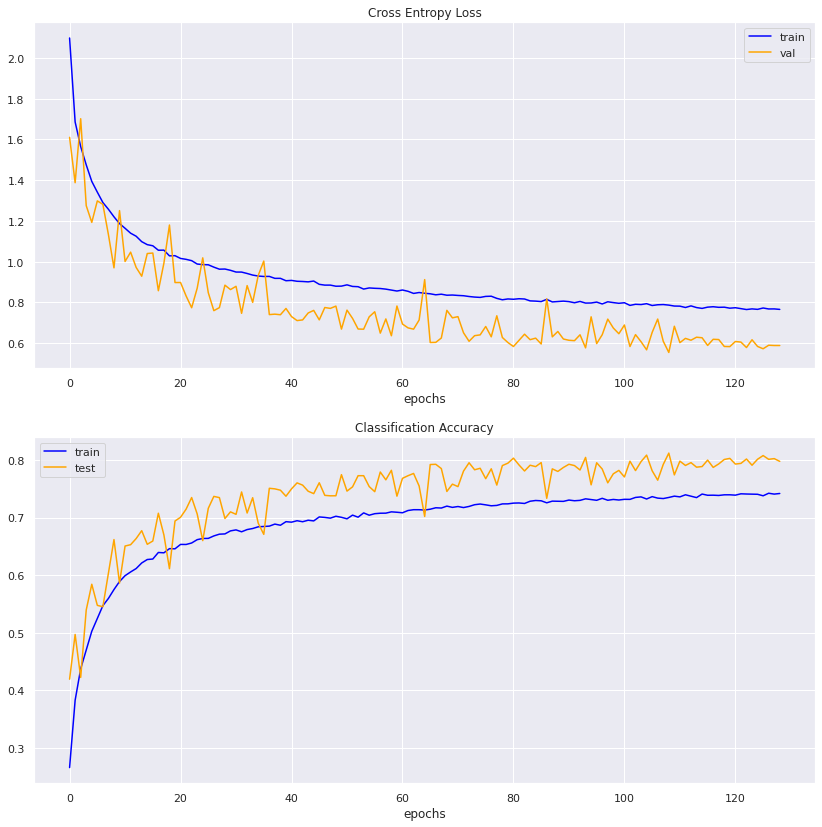

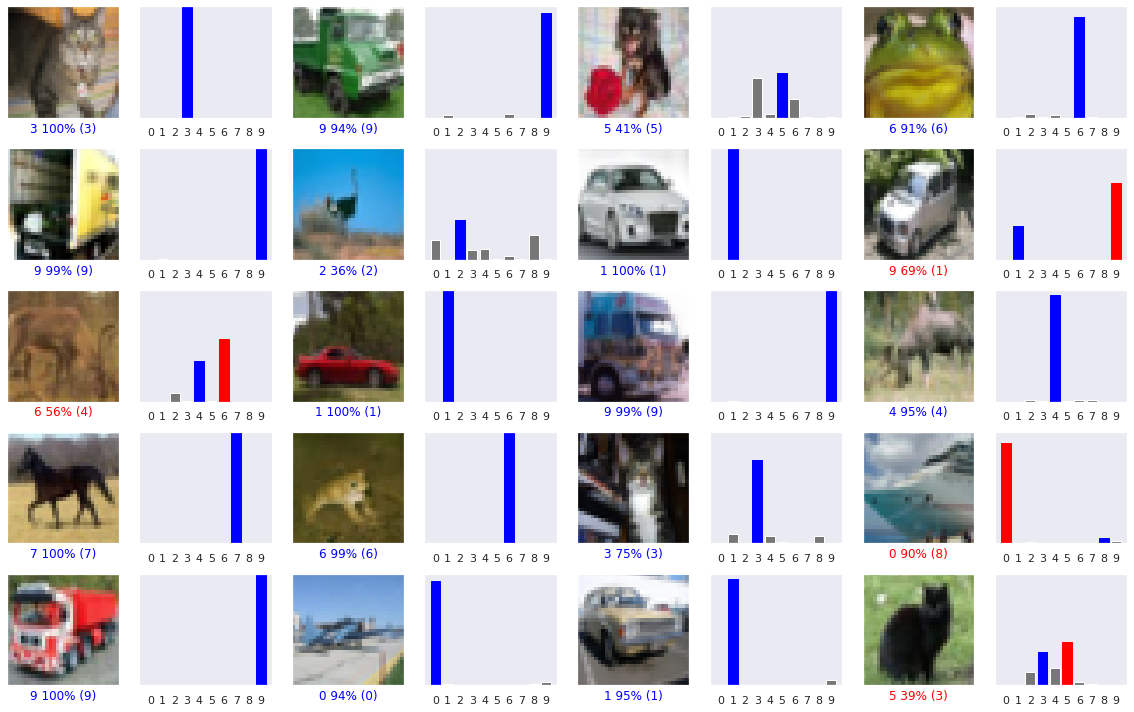

In [ ]:
def define_model(name):
  print(f'Model: {name}')
  # Arquitectura VGG de tres bloques.
  model = ks.Sequential(name=name)

  # Detector de características
  model.add(ks.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(ks.layers.BatchNormalization())
  model.add(ks.layers.Conv2D(32, (3,3), padding='same', activation='relu'))
  model.add(ks.layers.BatchNormalization())
  model.add(ks.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(ks.layers.Dropout(0.3))

  model.add(ks.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
  model.add(ks.layers.BatchNormalization())
  model.add(ks.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
  model.add(ks.layers.BatchNormalization())
  model.add(ks.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(ks.layers.Dropout(0.5))

  model.add(ks.layers.Conv2D(128, (3,3), padding='same', activation='relu'))
  model.add(ks.layers.BatchNormalization())
  model.add(ks.layers.Conv2D(128, (3,3), padding='same', activation='relu'))
  model.add(ks.layers.BatchNormalization())
  model.add(ks.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(ks.layers.Dropout(0.6))

  model.add(ks.layers.Flatten())
  model.add(ks.layers.Dense(512, activation='relu', kernel_initializer='he_uniform'))
  model.add(ks.layers.Dropout(0.3))
  model.add(ks.layers.Dense(128, activation='relu'))
  model.add(ks.layers.BatchNormalization())
  model.add(ks.layers.Dropout(0.5))
  model.add(ks.layers.Dense(10, activation='softmax')) 

  # Compilar modelo
  model.compile(optimizer='Adam', 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
 
  # Resumen
  model.summary()

  return model

# Lanzar pipeline
history=pipeline_data_augmentation('Modelo_VII')

### Modelo 8

######### ETAPA 1: CARGAR DATASET #########
######### ETAPA 2: PRE-PROCESAMIENTO #########
######### ETAPA 3: DEFINIR MODELO #########
Model: Modelo_VIII
Model: "Modelo_VIII"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (Non

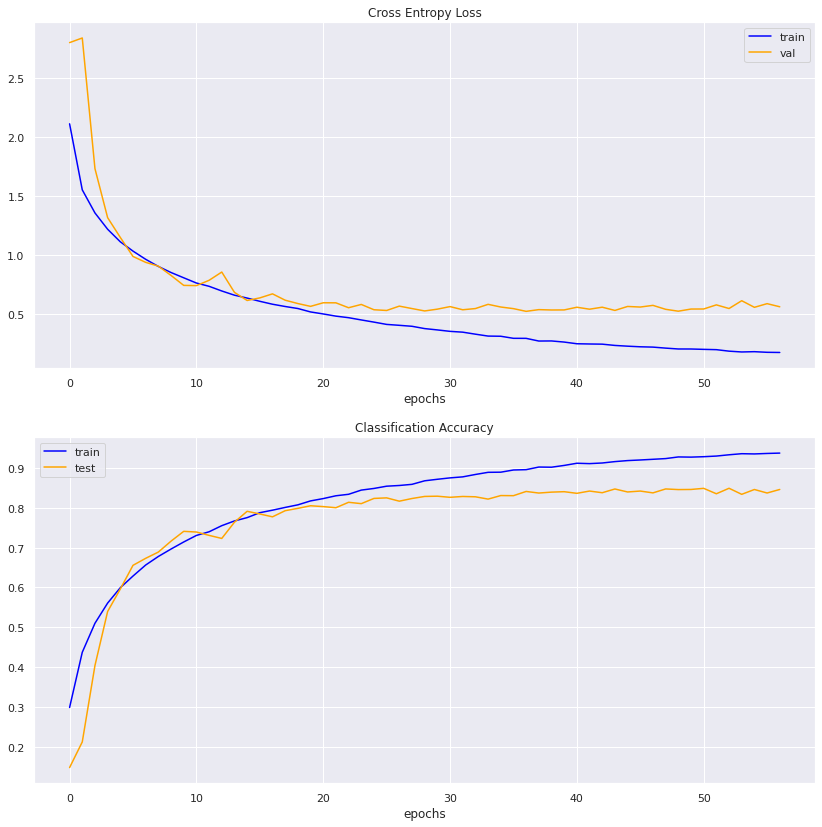

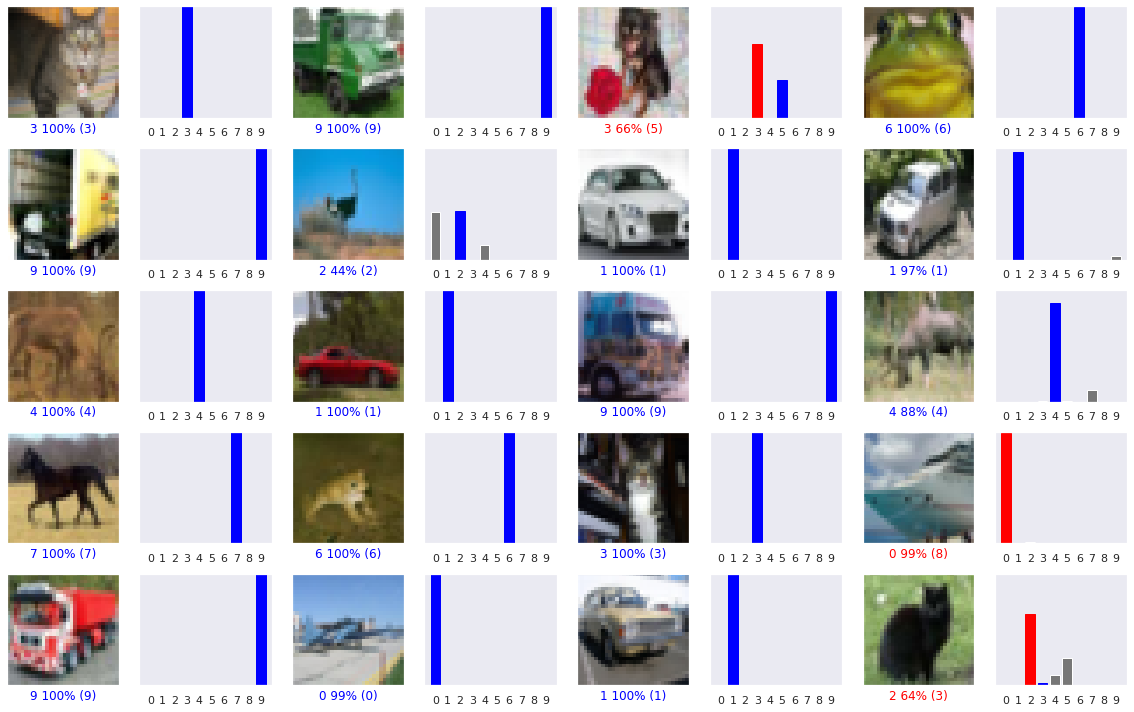

In [ ]:
def define_model(name):
  print(f'Model: {name}')
  # Arquitectura VGG de tres bloques.
  model = ks.Sequential(name=name)

  # Detector de características
  model.add(ks.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(ks.layers.BatchNormalization())
  model.add(ks.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.BatchNormalization())
  model.add(ks.layers.MaxPooling2D((2, 2)))
  model.add(ks.layers.Dropout(0.2))

  # BLOQUE 2 - Detector de características
  model.add(ks.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.BatchNormalization())
  model.add(ks.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.BatchNormalization())
  model.add(ks.layers.MaxPooling2D((2, 2)))
  model.add(ks.layers.Dropout(0.35))

  # BLOQUE 3 - Detector de características
  model.add(ks.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.BatchNormalization())
  model.add(ks.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.BatchNormalization())
  model.add(ks.layers.MaxPooling2D((2, 2)))
  model.add(ks.layers.Dropout(0.4))

  # BLOQUE 4 - Salida de la red.
  model.add(ks.layers.Flatten())
  model.add(ks.layers.Dense(512, activation='relu', kernel_initializer='he_uniform'))
  model.add(ks.layers.BatchNormalization())
  model.add(ks.layers.Dropout(0.3))
  model.add(ks.layers.Dense(512, activation='relu', kernel_initializer='he_uniform'))
  model.add(ks.layers.BatchNormalization())
  model.add(ks.layers.Dropout(0.3))
  model.add(ks.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(ks.layers.BatchNormalization())
  model.add(ks.layers.Dropout(0.3))
  model.add(ks.layers.Dense(10, activation='softmax', kernel_initializer='he_uniform'))


  # Compilar modelo
  model.compile(optimizer='Adam', 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
 
  # Resumen
  model.summary()

  return model

# Lanzar pipeline
history=pipeline('Modelo_VIII')

### Modelo 9

No es necesario utilizar la técnica __'data augmentation'__ para la validación mientras se ajusta el modelo, sin embargo encuentro que se obtiene una mejor precisión de validación si se utiliza. Esto es probablemente porque el modelo puede aprender características más generalizadas si los datos de validación también se aumentan. He utilizado sólo algunas de las muchas funcionalidades disponibles de la función de aumento. 

Además se utiliza la técnica de '__Learning Annealer__' para modificar la tasa de aprendizaje después de un número determinado de epochs o después de que se cumpla una determinada condición. En este caso se cambiará la tasa de aprendizaje si el error de validación no se reduce después de un número determinado de épocas (10).

######### ETAPA 1: CARGAR DATASET #########
######### ETAPA 2: PRE-PROCESAMIENTO #########
######### ETAPA 3: DEFINIR MODELO #########
Model: Modelo_VIII
Model: "Modelo_VIII"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_36 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_37 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_24 (Dropout)         (Non

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/200
1333/1333 [==============================] - 71s 39ms/step - loss: 2.0320 - accuracy: 0.2856 - val_loss: 1.9762 - val_accuracy: 0.3126
Epoch 2/200
1333/1333 [==============================] - 51s 38ms/step - loss: 1.6568 - accuracy: 0.3983 - val_loss: 1.4668 - val_accuracy: 0.4689
Epoch 3/200
1333/1333 [==============================] - 51s 38ms/step - loss: 1.5274 - accuracy: 0.4509 - val_loss: 1.3937 - val_accuracy: 0.5006
Epoch 4/200
1333/1333 [==============================] - 51s 38ms/step - loss: 1.4431 - accuracy: 0.4855 - val_loss: 1.2936 - val_accuracy: 0.5343
Epoch 5/200
1333/1333 [==============================] - 51s 38ms/step - loss: 1.3604 - accuracy: 0.5164 - val_loss: 1.3491 - val_accuracy: 0.5327
Epoch 6/200
1333/1333 [==============================] - 51s 38ms/step - loss: 1.2965 - accuracy: 0.5410 - val_loss: 1.2346 - val_accuracy: 0.5688
Epoch 7/200
1333/1333 [==============================] - 50s 38ms/step - loss: 1.2441 - accuracy: 0.5634 - val_loss: 1

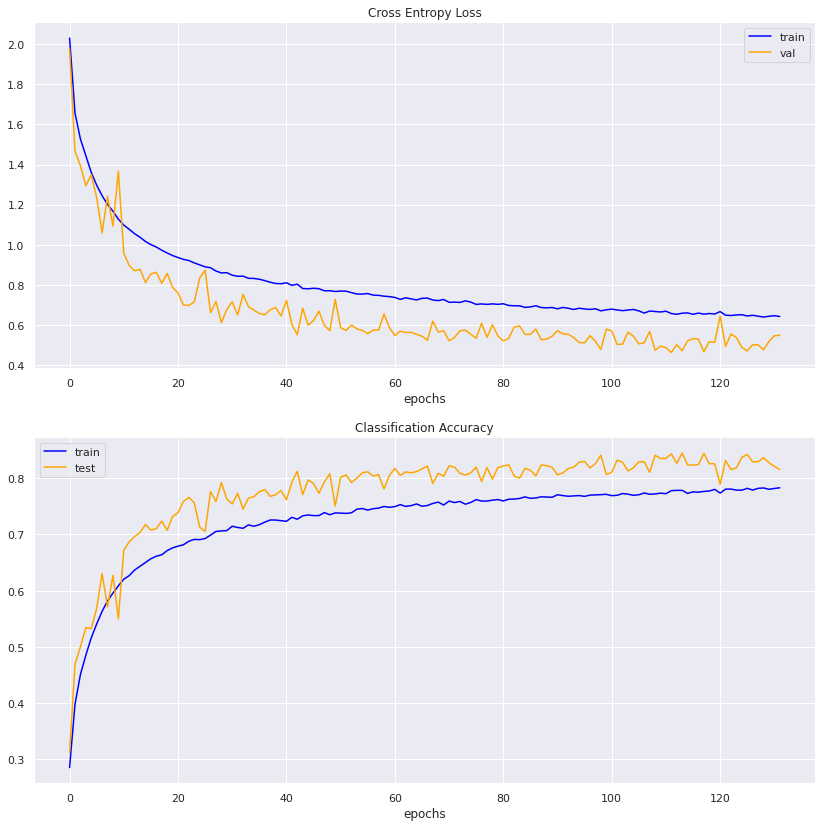

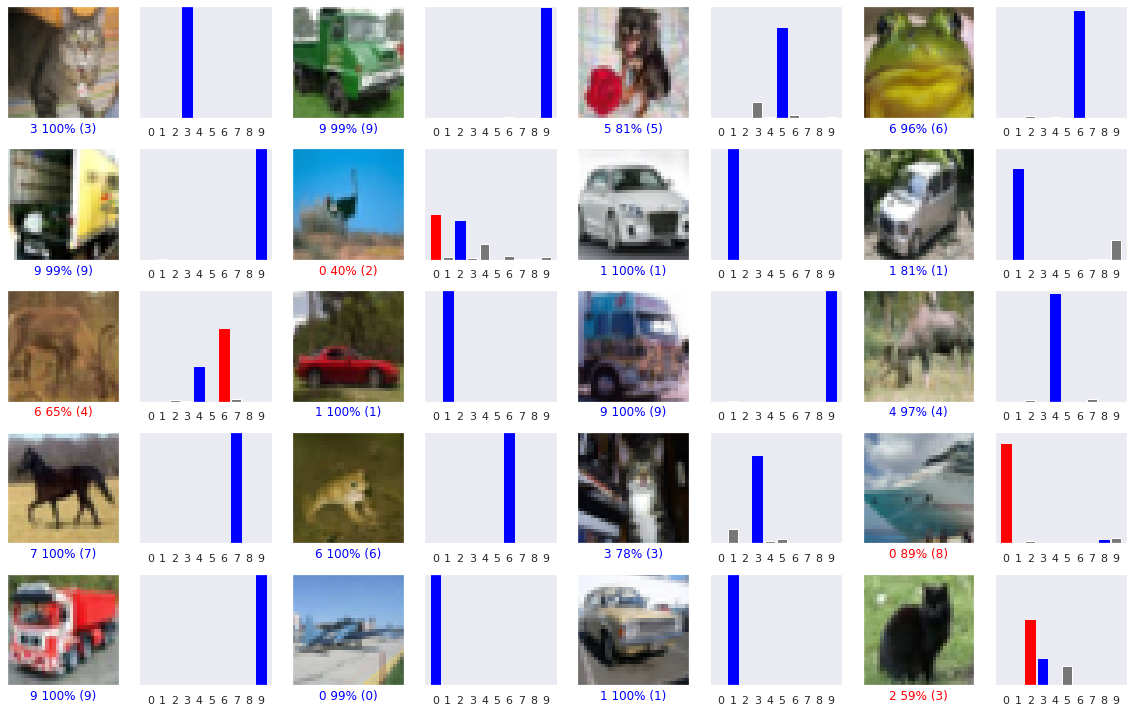

In [ ]:
def define_model(name):
  print(f'Model: {name}')
  # Arquitectura VGG de tres bloques.
  model = ks.Sequential(name=name)

  # Detector de características
  model.add(ks.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(ks.layers.BatchNormalization())
  model.add(ks.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.BatchNormalization())
  model.add(ks.layers.MaxPooling2D((2, 2)))
  model.add(ks.layers.Dropout(0.2))

  # BLOQUE 2 - Detector de características
  model.add(ks.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.BatchNormalization())
  model.add(ks.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.BatchNormalization())
  model.add(ks.layers.MaxPooling2D((2, 2)))
  model.add(ks.layers.Dropout(0.35))

  # BLOQUE 3 - Detector de características
  model.add(ks.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.BatchNormalization())
  model.add(ks.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(ks.layers.BatchNormalization())
  model.add(ks.layers.MaxPooling2D((2, 2)))
  model.add(ks.layers.Dropout(0.4))

  # BLOQUE 4 - Salida de la red.
  model.add(ks.layers.Flatten())
  model.add(ks.layers.Dense(512, activation='relu', kernel_initializer='he_uniform'))
  model.add(ks.layers.BatchNormalization())
  model.add(ks.layers.Dropout(0.3))
  model.add(ks.layers.Dense(512, activation='relu', kernel_initializer='he_uniform'))
  model.add(ks.layers.BatchNormalization())
  model.add(ks.layers.Dropout(0.3))
  model.add(ks.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(ks.layers.BatchNormalization())
  model.add(ks.layers.Dropout(0.3))
  model.add(ks.layers.Dense(10, activation='softmax', kernel_initializer='he_uniform'))


  # Compilar modelo
  model.compile(optimizer='Adam', 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
 
  # Resumen
  model.summary()

  return model

# Lanzar pipeline
history=pipeline_data_augmentation('Modelo_IX')

## Bibliografía
[1] How to Develop a CNN From Scratch for CIFAR-10 Photo Classification
 (url: https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/)

 [2] Very Deep Convolutional Networks for Large-Scale Image Recognition

 [3] Capa dropout en modelos de aprendizaje profundo con Keras
(url: https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/)

[4] Image Augmentation for Deep Learning using Keras and Histogram Equalization (url: https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085)